In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

# set plotting functions
matplotlib.rcParams['savefig.dpi'] = 500
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')
# get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/'
dataDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
 

# Import differential gene files for examination and plotting

## Write differential genes to list for metascape

In [3]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [4]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/'

In [5]:
gene_list_dict ={}

In [6]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob(diffpath+strain+'*control.vs.*control*.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.balbcj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.balbcj_control.scatter.txt


Write gene lists separately

In [7]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()


aj_union
227 genes
aj_intersection
33 genes
balb_union
230 genes
balb_intersection
45 genes
c57_union
236 genes
c57_intersection
69 genes


### Write gene lists together for combined GO analysis

In [8]:
meta_df = pd.DataFrame.from_dict(gene_list_dict, orient='index').T
meta_df.to_csv('./gene_lists/all_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.csv',
               # sep='',
               index=False)

### Try with homer

    for i in *genes*; do echo findGO.pl $i mouse ${i/.txt/_go} -cpu 4; done

### Read in go biological process terms

In [9]:
df_dict = {}
for i in np.sort(glob.glob('./gene_lists/*go/biological_process.txt')):
    df = pd.read_csv(i, sep='\t', index_col=0)
    df_dict[i.split('/')[2].split('_kupffer')[0]] = df.loc[:, ['Term', 'Enrichment', 'logP']]

In [10]:
df_dict.keys()

dict_keys(['aj_intersection', 'aj_union', 'balb_intersection', 'balb_union', 'c57_intersection', 'c57_union'])

In [11]:
df_dict['aj_union'].head()

,Term,Enrichment,logP
TermID,,,
GO:0002376,immune system process,1.774709e-14,-31.662555
GO:0006955,immune response,1.459091e-11,-24.950623
GO:0019886,antigen processing and presentation of exogeno...,2.286773e-09,-19.896124
GO:0002504,antigen processing and presentation of peptide...,5.999324e-09,-18.931619
GO:0002495,antigen processing and presentation of peptide...,5.999324e-09,-18.931619


# extract subset of terms for spider plot

In [12]:
n=5
top_terms = []
for i in ['aj_intersection', 'balb_intersection', 'c57_intersection']:
    top_terms.extend(df_dict[i].sort_values('logP', ascending=True).index.tolist()[:n])
    
top_terms_set = set(top_terms)

# create DF with term IDs and scores

In [13]:
df = df_dict['aj_intersection'].loc[top_terms_set, ['Term', 'logP']]
df = df.merge(df_dict['balb_intersection'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('_aj', '_balb'))
df = df.merge(df_dict['c57_intersection'].loc[top_terms_set, ['logP']],
              left_index=True,
              right_index=True,
              suffixes=('', '_c57'))

In [14]:
df.sort_values('logP_aj', ascending=True)

,Term,logP_aj,logP_balb,logP
TermID,,,,
GO:0043603,cellular amide metabolic process,-9.428986e+00,-1.173511e+00,-5.341794e+00
GO:0006518,peptide metabolic process,-8.436232e+00,-5.536452e-01,-6.744173e+00
GO:0021884,forebrain neuron development,-6.781011e+00,-3.090634e-12,-5.299106e-12
GO:0071654,positive regulation of chemokine (C-C motif) l...,-6.608386e+00,1.896539e-11,3.707463e-11
GO:0071652,regulation of chemokine (C-C motif) ligand 1 p...,-6.608386e+00,1.896539e-11,3.707463e-11
GO:0002376,immune system process,-6.121158e+00,-1.176567e+01,-7.658692e+00
GO:0002181,cytoplasmic translation,-2.636016e+00,8.579825e-12,-1.092401e+01
GO:0040012,regulation of locomotion,-2.808724e-11,-9.341078e+00,-5.328784e+00
GO:0002685,regulation of leukocyte migration,-2.443924e-11,-7.572861e+00,-1.120206e+01


# Plot potential nichenet ligands

In [15]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Read in raw expression values

In [16]:
tpm_mat = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('control')]

Read in nichenet ligands

In [17]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

### Intersection gene set

In [18]:
act = []
for key in gene_list_dict.keys():
    if 'intersection' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

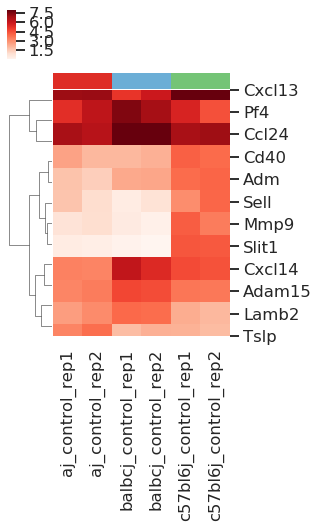

In [19]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26',
                  '#6baed6', '#6baed6',
                  '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

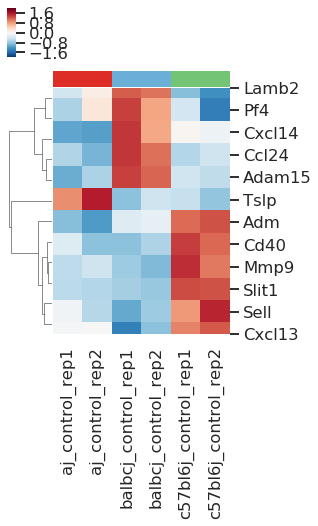

In [20]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26',
                  '#6baed6', '#6baed6',
                  '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Look at union gene set

In [21]:
act = []
for key in gene_list_dict.keys():
    if 'union' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

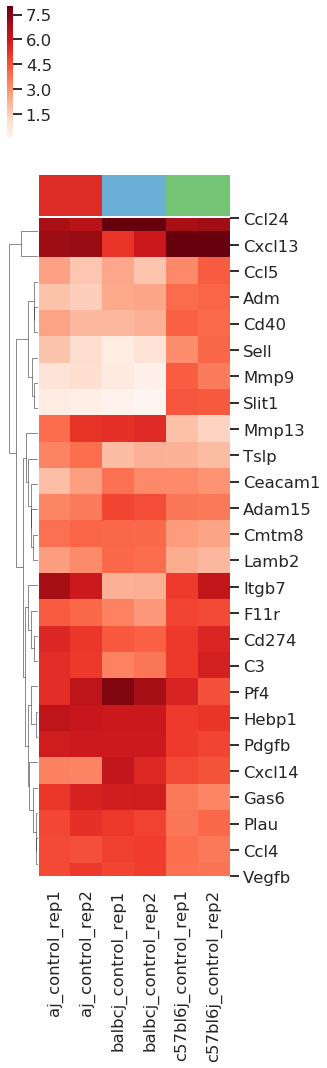

In [22]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26',
                  '#6baed6', '#6baed6',
                  '#74c476', '#74c476'],
    figsize=(4,16),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

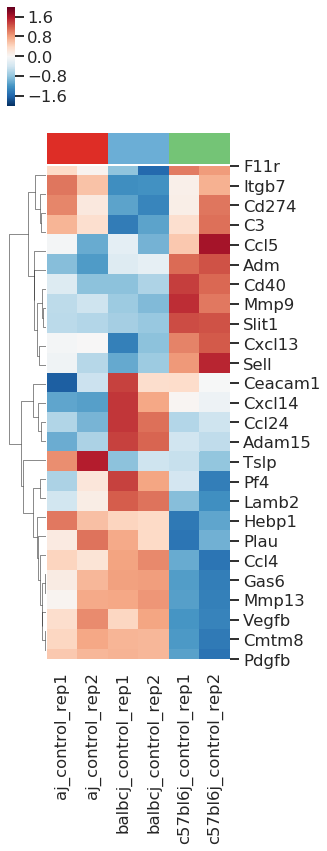

In [23]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26',
                  '#6baed6', '#6baed6',
                  '#74c476', '#74c476'],
    figsize=(4,12),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

# Plot potential nichenet receptors

Read in nichenet ligands

In [24]:
receptors = pd.read_csv(
    '/home/h1bennet/data/gene_lists/nichenet_receptors.csv')['to'].str.capitalize().tolist()
receptors[:5]

['Cxcr2', 'Cxcr1', 'Cxcr3', 'Cxcr4', 'Cxcr5']

### Intersection gene set

In [25]:
act = []
for key in gene_list_dict.keys():
    if 'intersection' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with receptors
act_receptors = act.intersection(receptors)
print(len(act), 'activated genes')
print(len(act_receptors), 'activated receptors')

147 activated genes
11 activated receptors


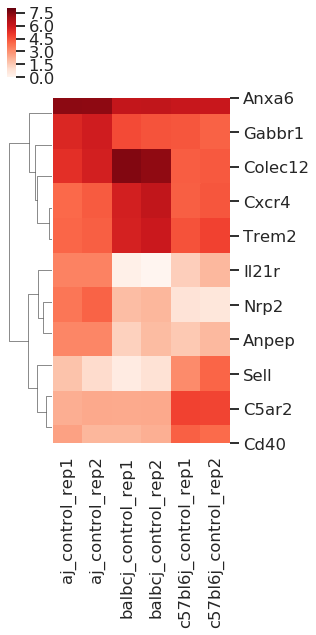

In [26]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_receptors]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    figsize=(4,8),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_receptors_clustermap.png', bbox_inches='tight')
# plt.close()

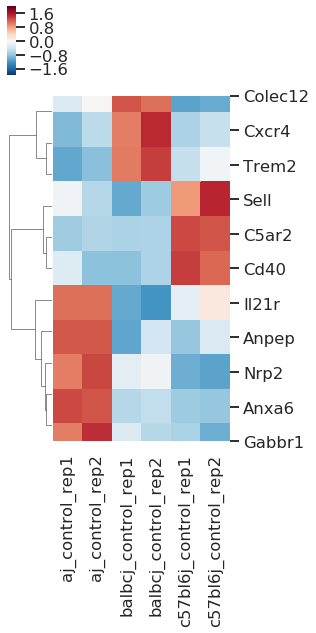

In [27]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_receptors]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    figsize=(4,8),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_receptors_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Look at union gene set

In [28]:
act = []
for key in gene_list_dict.keys():
    if 'union' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with receptors
act_receptors = act.intersection(receptors)
print(len(act), 'activated genes')
print(len(act_receptors), 'activated receptors')

535 activated genes
37 activated receptors


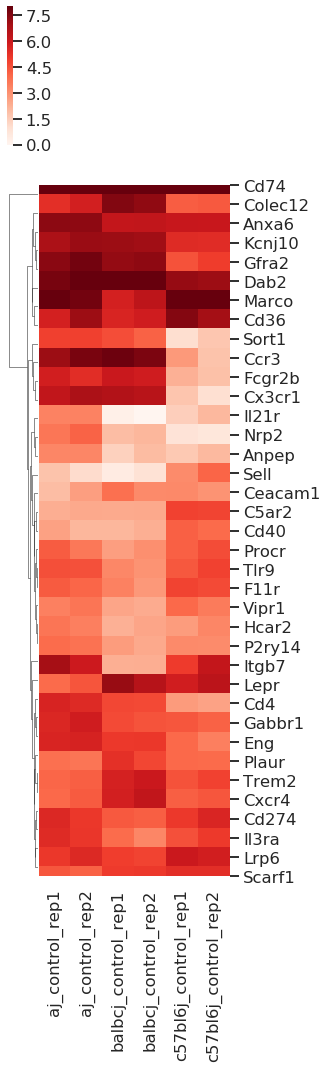

In [29]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_receptors]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    figsize=(4,16),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_receptors_clustermap.png', bbox_inches='tight')
# plt.close()

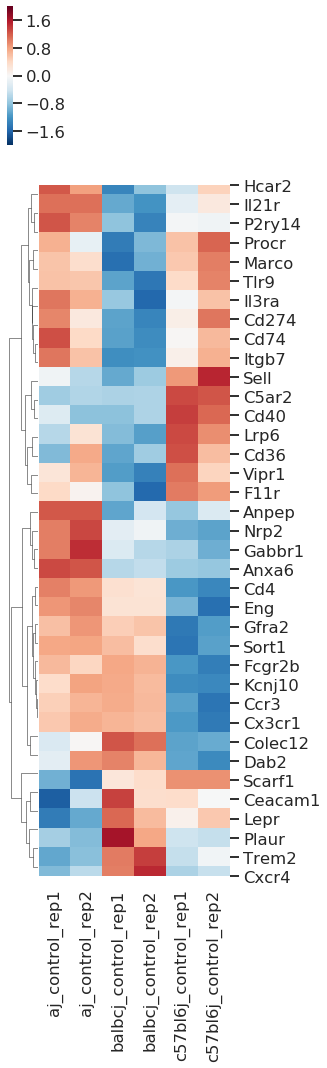

In [30]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_receptors]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    figsize=(4,16),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_receptors_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

# Plot single genes

In [9]:
tpm = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                  index_col=0,
                  sep='\t')

In [10]:
groups = [[0,1],
          [2,3],
          [4,5]]

group_labels = ['AJ Kupffer',
                'Balb/cJ Kupffer',
                'C57BL/6J Kupffer']

colors = ['#de2d26',
          '#6baed6',
          '#74c476']

In [11]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

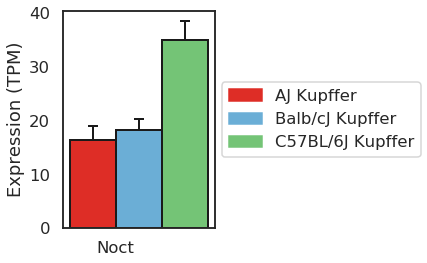

In [13]:
gene = ['Noct']

fig, axs = plt.subplots(1, 2,
                       figsize=(6, 4))
# plt.subplots_adjust(wspace=0.5)

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

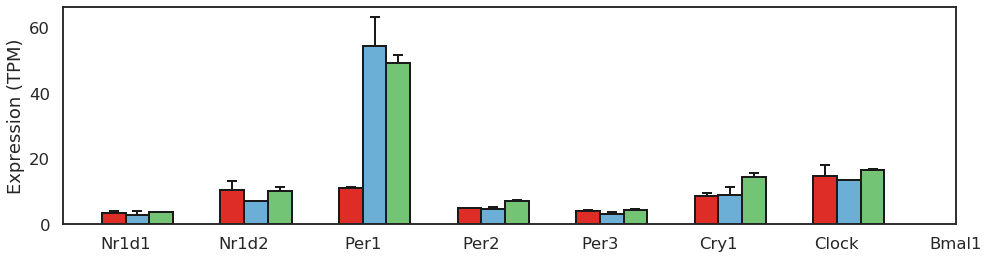

In [35]:
gene = ['Nr1d1', 'Nr1d2', 'Per1', 'Per2', 'Per3', 'Cry1', 'Clock', 'Bmal1']

fig, ax = plt.subplots(1, 1,
                       figsize=(16, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   # relative='True',
                   ax=ax)

ax.get_legend().remove()

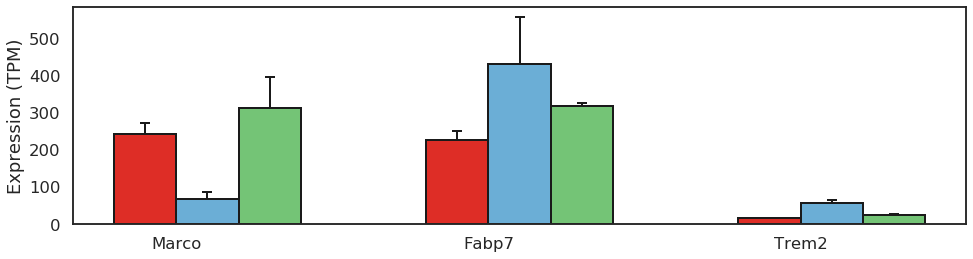

In [36]:
gene = ['Marco', 'Fabp7', 'Trem2']

fig, ax = plt.subplots(1, 1,
                       figsize=(16, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   # relative='True',
                   ax=ax)

ax.get_legend().remove()

In [37]:
tpm.index[tpm.index.str.contains('Stat')]

Index(['Stat5a', 'Stat3', 'Stat2', 'Stat1', 'Stat4', 'Stat6', 'Stat5b'], dtype='object')